In [83]:
import matplotlib, pickle
import numpy as np
import matplotlib.pyplot as plt
from pystan import stan
import corner

matplotlib.style.use('ggplot')
%matplotlib inline

In [84]:
class transit():

    def __init__(self,num_samples,A,B,t_c,w,sigma):
        self.num_samples = num_samples
        self.A = A
        self.B = B
        self.t_c = t_c
        self.w = w
        self.sigma = sigma

    def generate_data(self):
        self.t_sample = np.arange(self.num_samples)
        self.data = np.zeros(self.num_samples)
        
        for i,t in enumerate(self.t_sample):
            if (t<self.t_c-self.w/2.) or (t>self.t_c+self.w/2.):
                self.data[i] = np.random.normal(self.A,self.sigma,1)
                
            else: 
                self.data[i] = np.random.normal(self.A-self.B,self.sigma,1)

        return self.t_sample, self.data

    def plot_data(self,file_name):
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title('Mock transit data')
        ax.set_ylabel('Luminosity')
        ax.set_xlabel('Time')
        ax.scatter(self.t_sample, self.data)
        fig.savefig(file_name,bbox_inches='tight')
        return fig

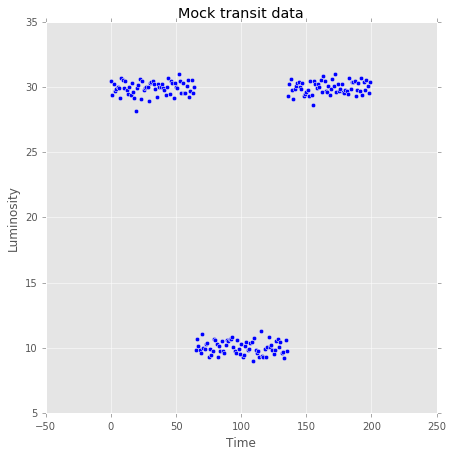

In [ ]:
"""
num_samples : number of samples
A : amplitude of mean signal
A - b : amplitude of mean signal during transit
t_c : time of mid-transit
w : width of transit
sigma : spread of noise

"""

num_samples = 200
A = 30
B = 20
t_c = 100
w = 70
t1=t_c-w/2
t2=t_c+w/2
sigma = 0.5 

trans = transit(num_samples,A,B,t_c,w,sigma)
data = trans.generate_data()
fig = trans.plot_data('plots/mock_data_plot.png')

In [ ]:
data = np.loadtxt('mock_transit_data.txt',unpack=True)

stan_data = {

    'N' : data[0].size,
    't' : data[0],
    'L' : data[1]

}

fit = stan(file='transit_model.stan', data=stan_data, iter=1000, chains=4)

results = fit.extract(permuted=True)

In [ ]:
fit.plot()
plt.show()

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_title('')
ax.set_ylabel('Luminosity')
ax.set_xlabel('Time')
ax.scatter(data[0], data[1],color='r',label='data')
ax.scatter(np.arange(200), samples['L_pred'][0],label='prediction')
ax.legend()
fig.savefig('plots/data_pred.png')

In [ ]:
corner_samples =  np.array([samples['A'],samples['B'],samples['sigma'],samples['t1'],samples['t2']]).T

In [ ]:
fig = corner.corner(corner_samples, 
                    labels=['A','B',r'$\sigma$','t1','t2'])
fig.savefig('plots/corner.png',bbox_inches='tight')